In [4]:
import os
import argparse
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

from keras.utils import multi_gpu_model

K.set_image_data_format('channels_last')

In [25]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
args={
'epochs':200,
'batch_size':32,
'lr':0.001, #Initial learning rate
'lr_decay':0.9, #The value multiplied by lr at each epoch. Set a larger value for larger epochs
'lam_recon':0.392, #The coefficient for the loss of decoder
'routings':3, #Number of iterations used in routing algorithm. should > 0
'shift_fraction':0.2, #Fraction of pixels to shift at most in each direction.
'debug':False, #Save weights by TensorBoard
'save_dir':'./result',
'digit':1,
'gpus':2,
'train_dir':'./data/train/',
'test_dir':'./data/test/'
}
args=dotdict(args)
if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

In [6]:
# Load Data

train_datagen = ImageDataGenerator(rescale = 1./255,
                                    horizontal_flip=True,
                                    rotation_range = args.shift_fraction,
                                    zoom_range = args.shift_fraction,
                                    width_shift_range = args.shift_fraction,
                                    height_shift_range = args.shift_fraction)
#generator = train_datagen.flow(x, y, batch_size=batch_size)
train_set = train_datagen.flow_from_directory(args.train_dir,
                                                target_size = (64, 64),
                                                batch_size = args.batch_size,
                                                class_mode = 'categorical')
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(args.test_dir,
                                            target_size = (64, 64),
                                            batch_size = 3753, #args.batch_size,
                                            class_mode = 'categorical')


Found 8751 images belonging to 5 classes.
Found 3753 images belonging to 5 classes.


In [7]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))
def train(model, args):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # callbacks
    log = callbacks.CSVLogger(args.save_dir + '/log.csv')
    tb = callbacks.TensorBoard(log_dir=args.save_dir + '/tensorboard-logs',
                               batch_size=args.batch_size, histogram_freq=int(args.debug))
    checkpoint = callbacks.ModelCheckpoint(args.save_dir + '/Model{epoch:02d}_{val_acc:.2f}.h5', monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=False, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * (args.lr_decay ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=args.lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., args.lam_recon],
                  metrics={'capsnet': 'accuracy'})

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    
    def train_generator(batch_size, shift_fraction=0.2):
        while 1:
            x_batch, y_batch = train_set.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])
    
    
    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    x_test, y_test = test_set.next()
    model.fit_generator(generator=train_generator(args.batch_size,args.shift_fraction),
                        steps_per_epoch=int(len(train_set.classes) / args.batch_size),
                        epochs=args.epochs,
                        validation_data = [[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, tb, checkpoint, lr_decay])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save(args.save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % args.save_dir)

    from utils import plot_log
    plot_log(args.save_dir + '/log.csv', show=True)

    return model

In [8]:

#define model
def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model

model, eval_model, manipulate_model = CapsNet(input_shape=train_set.image_shape,
                                                  n_class=train_set.num_classes,
                                                  routings=args.routings)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 56, 56, 256)  62464       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 24, 24, 256)  5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 18432, 8)     0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

In [ ]:
# train or model
train(model=model, args=args)

In [26]:
final_test_set = test_datagen.flow_from_directory(args.test_dir,
                                            target_size = (64, 64),
                                            batch_size = 3753, #args.batch_size,
                                            class_mode = 'categorical')

#Reconstruct the image
def manipulate_latent(model):
    print('-'*30 + 'Begin: manipulate' + '-'*30)
    x_test, y_test = final_test_set.next()
    index = np.argmax(y_test, 1) == args.digit
    number = np.random.randint(low=0, high=sum(index) - 1)
    x, y = x_test[index][number], y_test[index][number]
    x, y = np.expand_dims(x, 0), np.expand_dims(y, 0)
    noise = np.zeros([1, 5, 16])
    x_recons = []
    for dim in range(16):
        for r in [-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15]:
            tmp = np.copy(noise)
            tmp[:,:,dim] = r
            x_recon = model.predict([x, y, tmp])
            x_recons.append(x_recon)

    x_recons = np.concatenate(x_recons)

    img = combine_images(x_recons, height=16)
    image = img*255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + '/manipulate-%d.png' % args.digit)
    print('manipulated result saved to %s/manipulate-%d.png' % (args.save_dir, args.digit))
    print('-' * 30 + 'End: manipulate' + '-' * 30)

Found 3753 images belonging to 5 classes.


In [32]:
#function to test
final_test_set = test_datagen.flow_from_directory(args.test_dir,
                                            target_size = (64, 64),
                                            shuffle=False,
                                            batch_size = 3753, #args.batch_size,
                                            class_mode = 'categorical')

def test(model):
    x_test, y_test = final_test_set.next()
    y_pred, x_recon = model.predict(x_test, batch_size=100)
    print('-'*30 + 'Begin: test' + '-'*30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    print()
    print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    plt.show()
    
    print('-' * 30 + 'Test Metrics' + '-' * 30)
    np.savetxt("./result/capsnet_657.csv", y_pred, delimiter=",")
    y_pred = np.argmax(y_pred,axis = 1) 
    y_actual = np.argmax(y_test, axis = 1)

    classnames=[]
    for classname in final_test_set.class_indices:
        classnames.append(classname)
    confusion_mtx = confusion_matrix(y_actual, y_pred) 
    print(confusion_mtx)
    target_names = classnames
    print(classification_report(y_actual, y_pred, target_names=target_names))
    print("accuracy= ",(confusion_mtx.diagonal().sum()/confusion_mtx.sum())*100)

Found 3753 images belonging to 5 classes.


------------------------------Begin: test------------------------------
Test acc: 0.654143351985

Reconstructed images are saved to ./result/real_and_recon.png
------------------------------End: test------------------------------


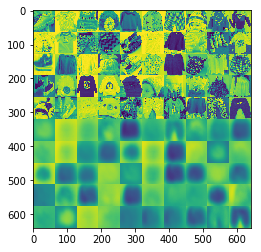

------------------------------Test Metrics------------------------------
[[473  27  49 196  50]
 [ 98 297  42  82  59]
 [143  17 169  92 153]
 [ 59  16  20 824  12]
 [ 61  17  38  67 692]]
                    precision    recall  f1-score   support

           BabyHat       0.57      0.59      0.58       795
         BabyPants       0.79      0.51      0.62       578
         BabyShirt       0.53      0.29      0.38       574
  womencasualshoes       0.65      0.89      0.75       931
womenlongsleevetop       0.72      0.79      0.75       875

       avg / total       0.65      0.65      0.64      3753

accuracy=  65.4143351985


In [33]:
##Evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model

model.load_weights('./result/trained_model.h5')

#manipulate_latent(manipulate_model)
test(model=eval_model)

